In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import KFold,cross_validate,train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore', message='FutureWarning') 
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用黑体显示中文
plt.rc('axes', unicode_minus=False) #解决 UserFarning: Glyph 8722 (NMINTS SIGW) missing from current font.问题

In [2]:
data = pd.read_csv("C:/Users/Turtles/Desktop/boom.csv")
# 数据类型调整之前变量情况
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2228 entries, 0 to 2227
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   senior      2228 non-null   int64 
 1   y_salary    2228 non-null   int64 
 2   edu         2228 non-null   int64 
 3   exp         2228 non-null   object
 4   size        2228 non-null   object
 5   stack       2228 non-null   int64 
 6   binsurance  2228 non-null   int64 
 7   minsurance  2228 non-null   int64 
 8   paleave     2228 non-null   int64 
 9   fpe         2228 non-null   int64 
 10  ebenefit    2228 non-null   int64 
 11  cclass      2228 non-null   int64 
 12  internet    2228 non-null   int64 
 13  jclass      2228 non-null   int64 
dtypes: int64(12), object(2)
memory usage: 243.8+ KB


In [3]:
data.describe()

,senior,y_salary,edu,stack,binsurance,minsurance,paleave,fpe,ebenefit,cclass,internet,jclass
count,2228.000000,2228.000000,2228.000000,2228.00000,2228.000000,2228.000000,2228.000000,2228.000000,2228.000000,2228.000000,2228.000000,2228.000000
mean,0.594255,167.723070,1.378366,0.25000,0.787253,0.312837,0.718133,0.572711,4.469479,2.132406,0.673698,5.631508
std,0.491146,130.817982,0.790615,0.43311,0.409342,0.463753,0.450010,0.494796,2.954294,1.048432,0.468964,2.782044
min,0.000000,40.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,80.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,3.000000
50%,1.000000,126.000000,1.000000,0.00000,1.000000,0.000000,1.000000,1.000000,5.000000,2.000000,1.000000,6.000000
75%,1.000000,209.000000,2.000000,0.25000,1.000000,1.000000,1.000000,1.000000,7.000000,3.000000,1.000000,8.000000
max,1.000000,707.000000,3.000000,1.00000,1.000000,1.000000,1.000000,1.000000,10.000000,4.000000,1.000000,10.000000


把edu, p_class, csize,cclass（城市等级），min_exp变成一个整型有序变量和分类变量的结果对比一下

In [6]:
# 数据预处理

# 唯一的连续变量
# ebenefit

# 分类变量列表
data['size'] = data['size'].apply(str)
data['edu'] = data['edu'].apply(str)
data['exp'] = data['exp'].apply(str)
data['cclass']= data['cclass'].apply(str)
data['jclass']= data['jclass'].apply(str)

# 虚拟变量列表
data['senior'] = data['senior'].apply(str)
data['stack'] = data['stack'].apply(str)
data['binsurance'] = data['binsurance'].apply(str)
data['minsurance'] = data['minsurance'].apply(str)
data['paleave'] = data['paleave'].apply(str)
data['fpe'] = data['fpe'].apply(str)
data['internet'] = data['internet'].apply(str)

# portion特别对待
# data['p_class'] = data['p_class'].apply(str)

In [7]:
# 数据类型调整之后变量情况
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2228 entries, 0 to 2227
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   senior      2228 non-null   object
 1   y_salary    2228 non-null   int64 
 2   edu         2228 non-null   object
 3   exp         2228 non-null   object
 4   size        2228 non-null   object
 5   stack       2228 non-null   object
 6   binsurance  2228 non-null   object
 7   minsurance  2228 non-null   object
 8   paleave     2228 non-null   object
 9   fpe         2228 non-null   object
 10  ebenefit    2228 non-null   int64 
 11  cclass      2228 non-null   object
 12  internet    2228 non-null   object
 13  jclass      2228 non-null   object
dtypes: int64(2), object(12)
memory usage: 243.8+ KB


In [8]:
data.describe()

,y_salary,ebenefit
count,2228.000000,2228.000000
mean,167.723070,4.469479
std,130.817982,2.954294
min,40.000000,0.000000
25%,80.000000,2.000000
50%,126.000000,5.000000
75%,209.000000,7.000000
max,707.000000,10.000000


In [9]:
# 构建X特征值
features = [# 分类变量列表
            "size","edu","exp", "cclass", "jclass",
            # 连续变量列表
            "ebenefit",
            # 虚拟变量列表
            "senior",
            "stack","binsurance","minsurance","paleave","fpe",
            "internet"]
X = data[features]

# 处理分类变量，转变为虚拟变量
X = pd.get_dummies(X, drop_first=True)

# 构建输出变量

# 是否取对数
data['y_salary_log'] = data['y_salary'].apply(np.log)

y = data['y_salary_log']

# 划分训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
# 标准化处理一下（只能对连续变量标准化处理）
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# scaler = MinMaxScaler()
continuous_feature = [
                      "ebenefit"
                      ]

# 复制前述中的X_train, X_test， 并重新命名为standard_X_train， standard_X_test
standard_X_train = X_train
standard_X_test = X_test

# 分别对训练集和测试集中的连续特征进行标准化缩放
standard_X_train[continuous_feature] = scaler.fit_transform(standard_X_train[continuous_feature]) 
standard_X_test[continuous_feature] = scaler.fit_transform(standard_X_test[continuous_feature]) 

D:\Anaconda3-2021.11-Windows-x86_64\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
D:\Anaconda3-2021.11-Windows-x86_64\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [11]:
standard_X_train.describe()

,ebenefit,size_100-499人,size_1000-9999人,size_10000人以上,size_20-99人,size_500-999人,edu_1,edu_2,edu_3,exp_1到3,...,jclass_7,jclass_8,jclass_9,senior_1,stack_1,binsurance_1,minsurance_1,paleave_1,fpe_1,internet_1
count,1.782000e+03,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,...,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000,1782.000000
mean,-1.236696e-16,0.204265,0.173962,0.227834,0.217172,0.057239,0.449495,0.358586,0.071268,0.271044,...,0.096521,0.070707,0.081369,0.592031,0.248036,0.790685,0.310887,0.717733,0.572391,0.670595
std,1.000281e+00,0.403277,0.379183,0.419553,0.412436,0.232364,0.497582,0.479720,0.257345,0.444623,...,0.295387,0.256407,0.273478,0.491595,0.431994,0.406934,0.462986,0.450229,0.494871,0.470129
min,-1.507226e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.302566e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.532869e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
75%,8.621676e-01,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.877622e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## AdaBoost 提升法

In [12]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import KFold, cross_validate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.0s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


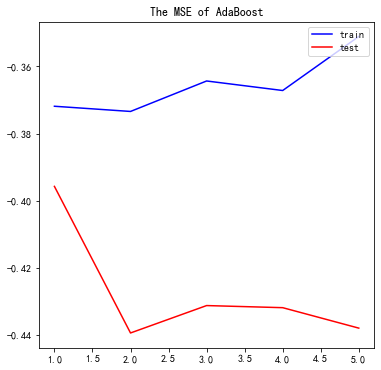

Adaboost的均方误差为： 0.4273037438911088


In [104]:
# AdaBoost提升法，通过每一轮自身的数去影响下一轮数的确定与影响，下一轮数值的确定是依据上一轮数的错误了确定的
# adaboost采用“自适应提升”，利用它本身的算法特性来拟合
# 默认的基学习器为决策树
# 引入AdaBoostRegressor算法
base_estimators = DTR(max_depth=5, random_state = 0)
adaboost = AdaBoostRegressor(base_estimator=base_estimators, # 即使填写none，仍然默认使用决策树作为基学习器
                             n_estimators=200, 
                             learning_rate=1.0, 
                             loss='exponential', # ‘linear','square’,'exponential’
                             random_state=0, 
                             )
# 设置cv参数，5折交叉验证
cv = KFold(n_splits=5, shuffle=True, random_state=0)

#  交叉验证的评判指标建立
validation_ada = cross_validate(adaboost, standard_X_train, y_train, #X, y,
                                scoring='neg_root_mean_squared_error', # 这里用均方根误差，对应上边square的loss rate
                                cv=cv,
                                n_jobs=-1,
                                verbose=True, # 显示运行进度，算的慢让电脑跑着就行
                                return_train_score=True # 显示训练集的得分
                                )

# 交叉验证的可视化
plt.figure(figsize = (6,6))
plt.plot(range(1,6), validation_ada['train_score'], 'b-', label = 'train')
plt.plot(range(1,6), validation_ada['test_score'], 'r-', label = 'test')
plt.legend(loc='upper right') 
plt.title('The MSE of AdaBoost')
plt.show()
print('Adaboost的均方误差为：', abs(validation_ada['test_score']).mean())

In [105]:
# Adaboost的均方误差为： 0.4273037438911088

## 1.基于Hyperopt实现TPE优化Adaboost

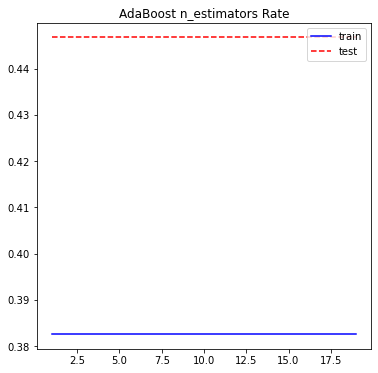

In [12]:
# 绘制n_estimators的学习率曲线

# 创建得分列表存储
trainscore_ada_n = []
testscore_ada_n = []

# 搭建参数空间的取值的寻找平台
for i in range(1,20):
    # 引入AdaBoostRegressor算法
    base_estimators = DTR(max_depth=5, min_samples_split=10, min_samples_leaf=4, max_features="auto", random_state = 0)
#     max_depth=10,min_samples_split=10,min_samples_leaf=4,max_features为auto,random_state=0
    adaboost = AdaBoostRegressor(base_estimator=base_estimators, # 即使填写none，仍然默认使用决策树作为基学习器
                                 n_estimators=200, 
                                 learning_rate=1.0, 
                                 loss='exponential', # 'liner','square','exponential'
                                 random_state=0, 
                                 )
    
    # 设置cv参数，5折交叉验证
    cv = KFold(n_splits=5, shuffle=True, random_state=0) 
    
    #  交叉验证的评判指标建立           
    validation_ada = cross_validate(adaboost, standard_X_train, y_train,
                                    scoring='neg_root_mean_squared_error', # 这里用均方根误差，对应上边square的loss rate
                                    cv=cv,
                                    n_jobs=-1,
                                    verbose=False, # 显示运行进度，算的慢让电脑跑着就行
                                    return_train_score=True # 显示训练集的得分
                                    )
    trainscore_ada_n.append(abs(validation_ada['train_score']).mean())
    testscore_ada_n.append(abs(validation_ada['test_score']).mean())

# 交叉验证的可视化
plt.figure(figsize = (6,6))
plt.plot(range(1,20), trainscore_ada_n, linestyle = '-', color = 'b', label = 'train')
plt.plot(range(1,20), testscore_ada_n, linestyle = '--', color = 'r', label = 'test')
plt.legend(loc='upper right')
plt.title('AdaBoost n_estimators Rate')
plt.show()

## 2.开始优化

In [17]:
# 安装一下，基于PTE的拟合模型
! pip install hyperopt -i https://pypi.doubanio.com/simple

Looking in indexes: https://pypi.doubanio.com/simple


In [18]:
import hyperopt
from hyperopt import fmin, tpe, Trials, hp, partial
from hyperopt.early_stop import no_progress_loss

In [15]:
# 定义目标函数
def hyperopt_objective_adaboost(params):
#     base_estimators = DTR(max_depth = 5, random_state = 0)
    base_estimators = DTR(max_depth=10, min_samples_split=10, min_samples_leaf=4, max_features="auto", random_state = 0)
    adaboost = AdaBoostRegressor(base_estimator=base_estimators,
                                 n_estimators=int(params['n_estimators']), # 迭代次数越多，随机项带来的影响是否越小，但是箱线图上显示离散值偏多 
                                 learning_rate=params['learning_rate'], 
                                 loss=str(params['loss']), 
                                 random_state=0, 
                                 )
    
    # 设置cv参数，5折交叉验证
    cv = KFold(n_splits=5, shuffle=True, random_state=0) 
    
    #  交叉验证的评判指标建立           
    validation_ada_tpe = cross_validate(adaboost, standard_X_train, y_train,
                                        scoring = 'neg_root_mean_squared_error', # 这里用均方根误差，对应上边square的loss rate
                                        cv = cv,
                                        n_jobs=-1,
                                        verbose=False, # 显示运行进度，算的慢让电脑跑着就行
                                        return_train_score=True # 显示训练集的得分
                                        )
    return abs(validation_ada_tpe['test_score']).mean()

In [92]:
# 定义参数空间
params = {'n_estimators':hp.quniform('n_estimators',1,300,1),
          'learning_rate':hp.uniform('learning_rate',0.02,0.3),# 0.02,0.15；# 0.15,0.5
          'loss':hp.choice('loss',['square', 'exponential'])# 'liner'
          }

In [93]:
# 定义优化函数
def params_hyperopt_adaboost(max_evals=100):
    # 保存迭代过程
    trials = Trials()
    # 提前停止
    early_stop_fn = no_progress_loss(2950) # 比较运行次数与提前停止阈值
    # 定理代理模型
    algo = partial(tpe.suggest, n_startup_jobs=20, n_EI_candidates=50)
    best_params = fmin(hyperopt_objective_adaboost, # 目标函数
                       space=params, # 参数空间
                       algo=tpe.suggest, # 代理模型
                       # 也可以选择随机网格搜索：algo=hyperopt.rand.suggest
                       # algo=algo
                       max_evals=max_evals,
                       trials=trials,
                       early_stop_fn=early_stop_fn,
                       verbose=True # 显示运行进度，算的慢让电脑跑着就行
                       )
    # 打印最优参数，fmin会自动打印最佳分数
    print('Best Params:',best_params)
    return best_params, trials    

In [100]:
# 运行优化
best_params, trials = params_hyperopt_adaboost(1000)
print(trials.losses()[:10]) # 保留十位小数

100%|████████████████████████████████████████████| 1000/1000 [15:09<00:00,  1.10trial/s, best loss: 0.4189651705619646]
Best Params: {'learning_rate': 0.06831708585583224, 'loss': 0, 'n_estimators': 188.0}
[0.4250109019857324, 0.4231937237176586, 0.42478807486486214, 0.4217079126659854, 0.4230047718434739, 0.42239683485356155, 0.4259432854249009, 0.42218555827927917, 0.42439544450404665, 0.42660147310046315]


In [101]:
# 添加大量的分类变量数据

In [90]:
# 无p_class,有j_class，（200，（0.2,0.3），30）

In [ ]:
# 100%|████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.72trial/s, best loss: 0.4199883334288058]
# Best Params: {'learning_rate': 0.12781586826418026, 'loss': 1, 'n_estimators': 132.0}
# [0.42273514209277635, nan, 0.42421395378353494, 0.4219506587775352, 0.4224952469988262, 0.4210537041419348, nan, 0.42837160532799157, nan, nan]

In [1]:
# 这里会需要一定的时间跑出结果，跑不出来就稍微等一下

## 3.验证优化结果

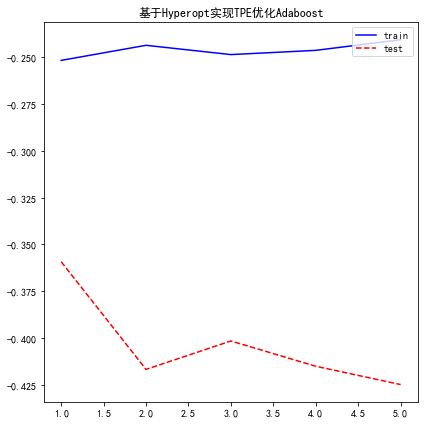

0.4034974374619679


In [106]:
# 验证优化结果
base_estimators = DTR(max_depth=10, min_samples_split=10, min_samples_leaf=4, max_features="auto", random_state = 0)
# {'max_depth': 10,'max_features': 'auto','min_samples_leaf': 5,'min_samples_split': 2}
adaboost = AdaBoostRegressor(base_estimator=base_estimators, 
                             n_estimators =188, # 这里添加优化过后的最优参数，#号替换数字
                             learning_rate=0.06831708585583224, 
                             loss='square', # 'liner','square','exponential'
                             random_state=0
                             )
cv = KFold(n_splits=5, shuffle=True, random_state=0) 
validation_ada_tpe = cross_validate(adaboost, standard_X_train, y_train,
                                    scoring = 'neg_root_mean_squared_error', # 这里用均方根误差，对应上边square的loss rate
                                    cv = cv,
                                    n_jobs=-1,
                                    verbose=False, # 显示运行进度，算的慢让电脑跑着就行
                                    return_train_score=True # 显示训练集的得分
                                    )
# 交叉验证的可视化
plt.figure(figsize = (6,6))
plt.plot(range(1,6), validation_ada_tpe['train_score'], 'b-', label = 'train')
plt.plot(range(1,6), validation_ada_tpe['test_score'], 'r--', label = 'test')
plt.legend(loc='upper right')
plt.title('基于Hyperopt实现TPE优化Adaboost')
plt.tight_layout()
plt.show()
print(abs(validation_ada_tpe['test_score']).mean())


## 87的MSE怎么说家人们

In [107]:
# 引入参数优化之后的AdaBoost回归模型
base_estimators = DTR(max_depth=10, min_samples_split=10, min_samples_leaf=4, max_features="auto", random_state = 0)
# {'max_depth': 10,'max_features': 'auto','min_samples_leaf': 5,'min_samples_split': 2}
adaboost = AdaBoostRegressor(base_estimator=base_estimators, 
                             n_estimators =188, # 这里添加优化过后的最优参数，#号替换数字
                             learning_rate=0.06831708585583224, 
                             loss='square', # 'liner','square','exponential'
                             random_state=0
                             )
# 在训练集上训练模型
adaboost.fit(standard_X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10,
                                                       max_features='auto',
                                                       min_samples_leaf=4,
                                                       min_samples_split=10,
                                                       random_state=0),
                  learning_rate=0.06831708585583224, loss='square',
                  n_estimators=188, random_state=0)

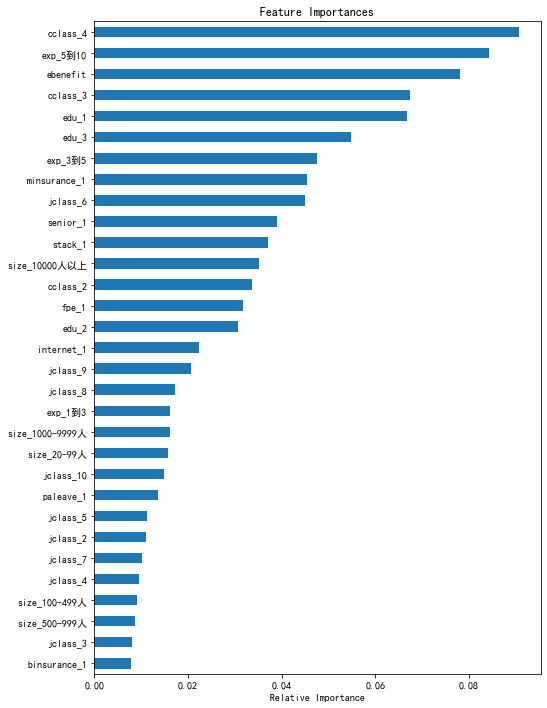

In [108]:
# 特征值重要性
importances = adaboost.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,12))
plt.title('Feature Importances')
weights.sort_values().plot(kind = 'barh')
plt.xlabel('Relative Importance')
plt.show()

In [109]:
weights.sort_values(ascending = False) ## 从大到小排序重要性

cclass_4           0.090769
exp_5到10           0.084327
ebenefit           0.078190
cclass_3           0.067465
edu_1              0.066763
edu_3              0.054729
exp_3到5            0.047513
minsurance_1       0.045428
jclass_6           0.044907
senior_1           0.039084
stack_1            0.037180
size_10000人以上      0.035095
cclass_2           0.033775
fpe_1              0.031770
edu_2              0.030744
internet_1         0.022447
jclass_9           0.020596
jclass_8           0.017218
exp_1到3            0.016198
size_1000-9999人    0.016133
size_20-99人        0.015696
jclass_10          0.014811
paleave_1          0.013544
jclass_5           0.011184
jclass_2           0.011048
jclass_7           0.010222
jclass_4           0.009552
size_100-499人      0.009082
size_500-999人      0.008756
jclass_3           0.008013
binsurance_1       0.007761
dtype: float64

In [110]:
# 评估模型
from sklearn.metrics import mean_squared_error, r2_score
y_pred = adaboost.predict(standard_X_test)
test_accuracy = adaboost.score(standard_X_test,y_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Accuracy:", round(test_accuracy,3))
print('Mean Squared Error:', mse)
print('R-squared:', r2)

Accuracy: 0.633
Mean Squared Error: 0.17224238847495515
R-squared: 0.6331065940801269


In [73]:
# Best Params: {'learning_rate'：0.06831708585583224, 'loss': 1, 'n_estimators': 188.0}
# Accuracy: 0.701
# Mean Squared Error: 0.13684517109400887
# R-squared: 0.700588540010558

In [56]:
# 添加大量的分类变量数据

## tpe寻找最优参数使mse在同一个量纲下缩小，达到拟合优化的效果
## mse降低→R2提高

In [ ]:
# AdaBoost总结：改进后的回归工资的模型，回归出来的结果为： 

In [ ]:
# 无p_class
# (n_estimators,learning_rate,迭代次数) = (300,(0.02,0.3),1000)
# Best Params: {'learning_rate'：0.06831708585583224, 'loss': 1, 'n_estimators': 188.0}
# Accuracy: 0.701
# Mean Squared Error: 0.13684517109400887
# R-squared: 0.700588540010558

# 调参之后，相对于与原来默认值而言： 
# Accuracy: 0.654
# Mean Squared Error: 0.15800143071262576
# R-squared: 0.6542995366815756
# 发生了改进，改进效果不错。

## GBDT梯度提升树

In [19]:
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import KFold, cross_validate

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


GradientBoosting的均方误差为： 0.387644813271632


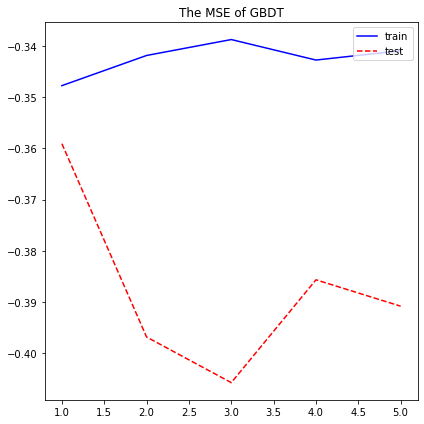

In [20]:
# GradientBoostingRegressor梯度提升树，更广泛的参数学习空间
# 引入GradientBoostingRegressor
gbr = GBR(random_state= 0 )

# 设置cv参数，5折交叉验证
cv = KFold(n_splits=5,random_state=0, shuffle=True)

#  交叉验证的评判指标建立
validation_gbr = cross_validate(gbr,standard_X_train, y_train,
                                scoring='neg_root_mean_squared_error',
                                cv=cv,
                                n_jobs=-1,
                                verbose=True,
                                return_train_score=True
                                )
print('GradientBoosting的均方误差为：', abs(validation_gbr['test_score']).mean())

# 交叉验证的可视化
plt.figure(figsize = (6,6))
plt.plot(range(1,6),validation_gbr['train_score'],'b-',label='train')
plt.plot(range(1,6),validation_gbr['test_score'],'r--',label='test')
plt.legend(loc=1)
plt.title('The MSE of GBDT')
plt.tight_layout()
plt.show()

In [ ]:
# GradientBoosting的均方误差为： 0.387644813271632

## 1.基于Hyperopt实现TPE优化GBDT

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parall

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parall

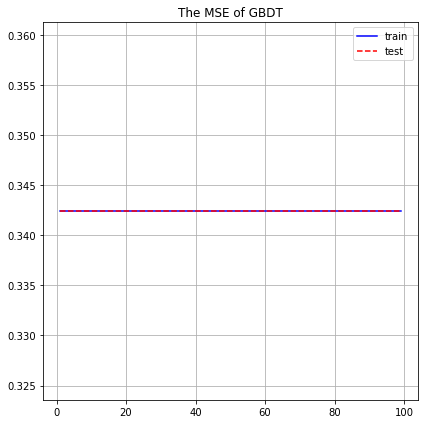

GradientBoosting的均方误差为： 0.387644813271632


In [16]:
# 绘制n_estimators的学习率曲线

# 创建得分列表存储
train_score_gbr_n = []
test_score_gbr_n = []

# 搭建参数空间的取值的寻找平台
for i in range(1,100):
    # 引入GradientBoostingRegressor算法
    gbr = GBR(random_state=0)

    # 设置cv参数，5折交叉验证
    cv = KFold(n_splits=5, random_state=0, shuffle=True)

    #  交叉验证的评判指标建立
    validation_gbr = cross_validate(gbr,standard_X_train, y_train,
                                    scoring='neg_root_mean_squared_error',
                                    cv=cv,
                                    n_jobs=-1,
                                    verbose=True,
                                    return_train_score=True
                                    )
    train_score_gbr_n.append(abs(validation_gbr['train_score']).mean())
    test_score_gbr_n.append(abs(validation_gbr['test_score']).mean())
    
# 交叉验证的可视化
plt.figure(figsize = (6,6))
plt.plot(range(1,100),train_score_gbr_n,'b-',label='train')
plt.plot(range(1,100),train_score_gbr_n,'r--',label='test')
plt.legend(loc=1)
plt.grid(True)
plt.title('The MSE of GBDT')
plt.axis('tight')
plt.tight_layout()
plt.show()
print('GradientBoosting的均方误差为：', abs(validation_gbr['test_score']).mean())

In [ ]:
# GradientBoosting的均方误差为： 0.387644813271632

## 2.开始优化

In [19]:
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, partial
from hyperopt.early_stop import no_progress_loss

In [31]:
# 定义目标函数
def hyperopt_objective_gbr(params):
# {'ccp_alpha': 0.0, 'max_depth': 22, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 100}
    rf = RFR(n_estimators=300,
             max_depth=12,
             max_features='auto',
             min_impurity_decrease=0.25,
             min_samples_leaf=2,
             ccp_alpha=0,
             criterion='poisson',
             random_state=0,
             verbose=False,
             n_jobs=1
             )
    gbr = GBR(n_estimators=int(params['n_estimators']),
              learning_rate=params['learning_rate'],
              init=rf, alpha=0.8,
              max_features=params['max_features'],
              subsample=params['subsample'],
              loss=params['loss'],
              max_depth=int(params['max_depth']),
              min_impurity_decrease=params['min_impurity_decrease'],
              random_state=0,
              verbose=False
              )
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    validation_loss = cross_validate(gbr, standard_X_train, y_train,
                                     scoring='neg_root_mean_squared_error',
                                     verbose=False,
                                     return_train_score=True,
                                     cv=cv,
                                     error_score='raise',
                                     n_jobs=-1
                                     )
    return abs(validation_loss['test_score']).mean()

In [90]:
# 定义参数空间
params_tpe_gbdt = {'n_estimators':hp.quniform('n_estimators', 75, 325, 5),
          'learning_rate':hp.quniform('learning_rate', 0.02, 0.3, 0.002),
          'max_features':hp.choice('max_features', ['auto','sqrt']),# 'log2',
          'subsample':hp.uniform('subsample', 0.35, 0.85), # 推荐在[0.5, 0.8]之间，默认是1.0
          'loss':hp.choice('loss', ['lad']), # 'huber','ls','quantile']), # 'squared_error','absolute_error'
          'max_depth':hp.quniform('max_depth', 12, 58, 1),
          'min_impurity_decrease':hp.quniform("min_impurity_decrease", 1, 16, 0.25)
          }
# 参数空间缩小之后
# (n_estimators,learning_rate,迭代次数) = (300,(0.06,0.2),1500) , (subsample) = (0.1, 0.6)，(min_impurity_decrease) = (2, 12), (max_depth) = (8, 50)
# rf, max_depth = 6→16

In [91]:
# 定义优化函数
def params_hyperopt_gbdt(max_evals=100):
    # 保存迭代过程
    trials = Trials()
    # 提前停止
    early_stop_fn = no_progress_loss(4500) # 比较运行次数与提前停止阈值
    # 定义代理模型
    algo = partial(tpe.suggest, n_startup_jobs=50, n_EI_candidates=20)
    best_params = fmin(hyperopt_objective_gbr, # 目标函数
                       space=params_tpe_gbdt, # 参数空间
                       algo=tpe.suggest, # 代理模型
                       # 也可以选择随机网格搜索：algo=hyperopt.rand.suggest
                       # algo=algo
                       max_evals=max_evals,
                       trials=trials,
                       early_stop_fn=early_stop_fn,
                       verbose=True # 显示运行进度，算的慢让电脑跑着就行
                       )
    # 打印最优参数，fmin会自动打印最佳分数
    print('Best Params:',best_params)
    return best_params, trials    

In [92]:
# 运行优化
best_params, trials = params_hyperopt_gbdt(500)
print(trials.losses()[:6]) # 保留六位小数

100%|█████████████████████████████████████████████| 500/500 [09:23<00:00,  1.13s/trial, best loss: 0.38473989543788517]
Best Params: {'learning_rate': 0.046, 'loss': 0, 'max_depth': 15.0, 'max_features': 0, 'min_impurity_decrease': 3.25, 'n_estimators': 215.0, 'subsample': 0.38694132157952005}
[0.4004494076652031, 0.4252357466187693, 0.41765111456488235, 0.4400519533914471, 0.3936785835365172, 0.4342306144801446]


In [93]:
# (n_estimators,learning_rate,迭代次数) = (300,(0.05,0.3),5000) , (subsample) = (0.2, 0.9)，(min_impurity_decrease) = (2, 16), (max_depth) = (8, 50)
# rf, max_depth = 6→16

In [94]:
# 引入大量分类变量

In [ ]:
# Best Params: {'learning_rate': 0.04, 'loss': 1, 'max_depth': 34.0, 'max_features': 2, 
#                 'min_impurity_decrease': 4.282700766969468, 'n_estimators': 199.0, 'subsample': 0.5}

In [ ]:
# Best Params: {'learning_rate': 0.064, 'loss': 1, 'max_depth': 46.0, 'max_features': 1, 
#               'min_impurity_decrease': 4.7250000000000005, 'n_estimators': 247.0, 'subsample': 0.445}

In [84]:
# Best Params: {'learning_rate': 0.038, 'loss': 1, 'max_depth': 37.0, 'max_features': 1, 
#               'min_impurity_decrease': 3.0500000000000003, 'n_estimators': 249.0, 'subsample': 0.4}

In [ ]:
# Best Params: {'learning_rate': 0.03, 'loss': 1, 'max_depth': 33.0, 'max_features': 0, 
#               'min_impurity_decrease': 3.0, 'n_estimators': 320.0, 'subsample': 0.30000000000000004}

In [ ]:
# Best Params: {'learning_rate': 0.074, 'loss': 0, 'max_depth': 43.0, 'max_features': 0, 
#                 'min_impurity_decrease': 3.3000000000000003, 'n_estimators': 183.0, 'subsample': 0.47500000000000003}

In [ ]:
# {'learning_rate': 0.06, 'loss': 2, 'max_depth': 41.0, 'max_features': 2, 
# 'min_impurity_decrease': 4.0, 'n_estimators': 235.0, 'subsample': 0.55}

In [ ]:
# {'learning_rate': 0.07, 'loss': 0, 'max_depth': 57.0, 'max_features': 0, 
#  'min_impurity_decrease': 4.0, 'n_estimators': 245.0, 'subsample': 0.4}

## 3.验证优化结果

In [95]:
# Best Params字典存储
dic_p={'learning_rate': 0.046, 'loss': 0, 'max_depth': 15.0, 'max_features': 0, 'min_impurity_decrease': 3.25, 'n_estimators': 215.0, 'subsample': 0.38694132157952005}

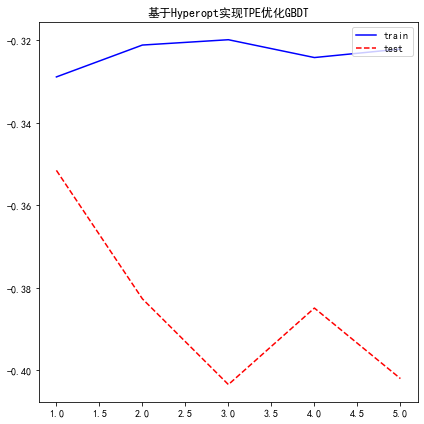

0.3849087153969407


In [111]:
# 验证优化结果
rf = RFR(n_estimators=300,
             max_depth=12,
             max_features='auto',
             min_impurity_decrease=0.25,
             min_samples_leaf=2,
             ccp_alpha=0,
             criterion='poisson',
             random_state=0,
             verbose=False,
             n_jobs=1
             )
# 将Best Params字典调用
hyperopt_gbr1 = GBR(learning_rate=dic_p.get('learning_rate'),
                   init=rf,
                   loss='lad', # ['ls','lad','huber','quantile']
                   max_depth=int(dic_p.get('max_depth')),
                   max_features='auto', # ['sqrt','auto']
                   min_impurity_decrease=dic_p.get('min_impurity_decrease'),
                   n_estimators=int(dic_p.get('n_estimators')),
                   subsample=dic_p.get('subsample'),
                   random_state=0,
                   verbose=False
                   )
cv = KFold(n_splits=5, shuffle=True, random_state=0)
validation_loss = cross_validate(hyperopt_gbr, standard_X_train, y_train,
                                 scoring='neg_root_mean_squared_error',
                                 verbose=False,
                                 return_train_score=True,
                                 cv=cv,
                                 error_score='raise',
                                 n_jobs=-1
                                 )

# 交叉验证的可视化
plt.figure(figsize = (6,6))
plt.plot(range(1,6), validation_loss['train_score'], 'b-', label = 'train')
plt.plot(range(1,6), validation_loss['test_score'], 'r--', label = 'test')
plt.legend(loc='upper right')
plt.title('基于Hyperopt实现TPE优化GBDT')
plt.tight_layout()
plt.show()
print(abs(validation_loss['test_score']).mean())

In [112]:
# 引入参数优化之后的GradientBoosting回归模型
rf = RFR(n_estimators=300,
             max_depth=12,
             max_features='auto',
             min_impurity_decrease=0.25,
             min_samples_leaf=2,
             ccp_alpha=0,
             criterion='poisson',
             random_state=0,
             verbose=False,
             n_jobs=1
             )
hyperopt_gbr = hyperopt_gbr1
# 在训练集上训练模型
hyperopt_gbr.fit(standard_X_train, y_train)

GradientBoostingRegressor(init=RandomForestRegressor(ccp_alpha=0,
                                                     criterion='poisson',
                                                     max_depth=12,
                                                     min_impurity_decrease=0.25,
                                                     min_samples_leaf=2,
                                                     n_estimators=300, n_jobs=1,
                                                     random_state=0,
                                                     verbose=False),
                          learning_rate=0.046, loss='lad', max_depth=15,
                          max_features='auto', min_impurity_decrease=3.25,
                          n_estimators=215, random_state=0,
                          subsample=0.38694132157952005, verbose=False)

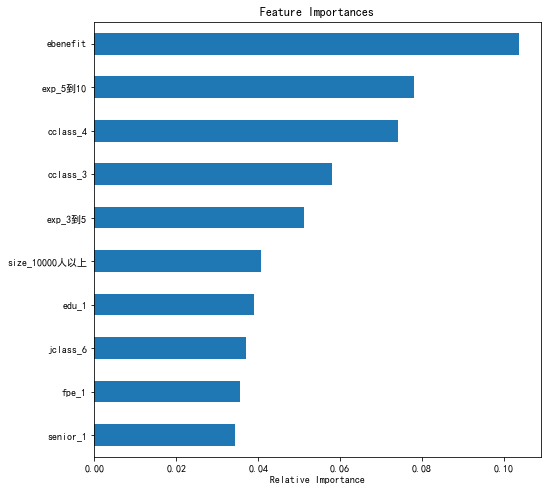

In [113]:
# 特征值重要性
importances = hyperopt_gbr.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.title('Feature Importances')
weights.sort_values()[-10:].plot(kind = 'barh')#[-10:]表示这么多特征中只想看前十重要的特征
plt.xlabel('Relative Importance')
plt.show()

In [114]:
weights.sort_values(ascending = False) ## 从大到小排序重要性

ebenefit           0.103733
exp_5到10           0.078116
cclass_4           0.074173
cclass_3           0.058119
exp_3到5            0.051088
size_10000人以上      0.040687
edu_1              0.038965
jclass_6           0.037136
fpe_1              0.035477
senior_1           0.034326
internet_1         0.030618
jclass_5           0.029134
cclass_2           0.028862
edu_3              0.027547
jclass_10          0.025252
minsurance_1       0.025250
jclass_8           0.024855
exp_1到3            0.024023
size_1000-9999人    0.023646
size_20-99人        0.023545
edu_2              0.023415
stack_1            0.022630
binsurance_1       0.019991
jclass_7           0.019529
jclass_9           0.017406
jclass_4           0.016819
size_100-499人      0.015272
paleave_1          0.013669
jclass_3           0.013513
size_500-999人      0.013061
jclass_2           0.010143
dtype: float64

In [115]:
# 评估模型
from sklearn.metrics import mean_squared_error, r2_score
y_pred = hyperopt_gbr.predict(standard_X_test)
test_accuracy = hyperopt_gbr.score(standard_X_test,y_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Accuracy", round(test_accuracy,3))
print('Mean Squared Error:', mse)
print('R-squared:', r2)

Accuracy 0.664
Mean Squared Error: 0.15754719075460227
R-squared: 0.6644088257202216


In [48]:
# GradientBoosting总结：改进后的回归工资的模型，回归出来的结果为： 

In [277]:
# 无portion
# (n_estimators,learning_rate,迭代次数) = (200,(0.1,0.2),10000)
# Best Params: {'learning_rate': 0.03, 'loss': 1, 'max_depth': 33.0, 'max_features': 0, 
#               'min_impurity_decrease': 3.0, 'n_estimators': 320.0, 'subsample': 0.30000000000000004}
# Accuracy 0.664
# Mean Squared Error: 0.15754719075460227
# R-squared: 0.6644088257202216

# 调参之前，相对于与原来默认值： 
# Accuracy 0.647
# Mean Squared Error: 0.16566691196719358
# R-squared: 0.6471130125514404
# 发生了改进，改进效果一般，可能是未优化前模型拟合效果已足够好。

In [ ]:
# 未加入boom_data之前，模型回归结果
# Best Params: {'learning_rate': 0.03, 'loss': 1, 'max_depth': 33.0, 'max_features': 0, 
#               'min_impurity_decrease': 3.0, 'n_estimators': 320.0, 'subsample': 0.30000000000000004}
# Accuracy 0.706
# Mean Squared Error: 0.13441954778220924
# R-squared: 0.7058957014643695


# 调参之后，相对于与原来默认值： 
# Accuracy 0.688
# Mean Squared Error: 0.14256207508952198
# R-squared: 0.6880801953007535